##### Bayesian Neural Network is used to improve ANN match of stock price difference from previous trading day data and technical indicators

In [54]:
import pandas as pd

import torch
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

In [55]:
df = pd.read_csv('data_model.csv', header=0, parse_dates=[0])
df_cleaned = df.dropna()
df_cleaned.head(5)

,Date,Diff,Close-Open,High-Low,RSI,Close-EMA,MACD-Signal,ADX,CCI,NormATR,Close-BBup,Close-BBmid,Close-BBlow,Diff_t+1
33,2021-06-14,12.50,20.45,216.55,71.283947,220.522136,-11.062793,30.701480,73.768483,1.013346,-58.001894,66.97,191.941894,57.40
34,2021-06-15,57.40,2.30,59.20,72.757895,240.865852,-10.284952,30.241329,131.489399,0.977958,-60.536263,98.54,257.616264,-101.70
35,2021-06-16,-101.70,-79.95,138.25,66.267762,120.610405,-18.454491,29.063859,86.183101,0.976589,-118.251497,-29.60,59.051497,-76.15
36,2021-06-17,-76.15,43.10,152.60,61.821008,38.532351,-30.131212,27.133862,-3.409170,0.980699,-213.266636,-96.48,20.306636,-8.05
37,2021-06-18,-8.05,-73.15,310.60,61.352321,26.418037,-38.979394,25.979041,-73.215266,1.052577,-223.182481,-81.33,60.522481,63.15


In [56]:
sc = MinMaxScaler()

# X_scale_dataset = sc.fit_transform(df_cleaned.iloc[:,1:-1])
X_scale_dataset = df_cleaned.iloc[:,1:-1].to_numpy()
y_dataset = df_cleaned.iloc[:,-1].to_numpy()

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_scale_dataset, y_dataset, train_size=0.7, random_state=42, shuffle=False)

In [58]:
data_target = y_train
data_feature = X_train

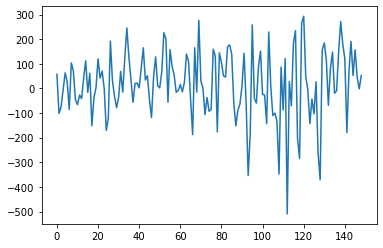

In [59]:
plt.plot(data_target)

In [60]:
data_feature.shape

(149, 12)

In [61]:
model = Sequential()
model.add(Dense(32, input_dim=12, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.fit(data_feature, data_target.reshape(-1,1), epochs=150, batch_size=10)

Epoch 1/150
15/15 [==============================] - 1s 2ms/step - loss: 19614.8789 - root_mean_squared_error: 140.0531
Epoch 2/150
15/15 [==============================] - 0s 2ms/step - loss: 18239.3398 - root_mean_squared_error: 135.0531
Epoch 3/150
15/15 [==============================] - 0s 2ms/step - loss: 17808.1133 - root_mean_squared_error: 133.4470
Epoch 4/150
15/15 [==============================] - 0s 2ms/step - loss: 17146.4512 - root_mean_squared_error: 130.9445
Epoch 5/150
15/15 [==============================] - 0s 1ms/step - loss: 16976.8398 - root_mean_squared_error: 130.2952
Epoch 6/150
15/15 [==============================] - 0s 2ms/step - loss: 16750.7363 - root_mean_squared_error: 129.4246
Epoch 7/150
15/15 [==============================] - 0s 2ms/step - loss: 16463.4883 - root_mean_squared_error: 128.3101
Epoch 8/150
15/15 [==============================] - 0s 2ms/step - loss: 16070.8369 - root_mean_squared_error: 126.7708
Epoch 9/150
15/15 [=====================

5/5 [==============================] - 0s 987us/step


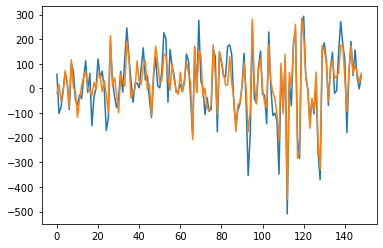

In [62]:
plt.plot(data_target)
plt.plot(model.predict(data_feature))

3/3 [==============================] - 0s 2ms/step


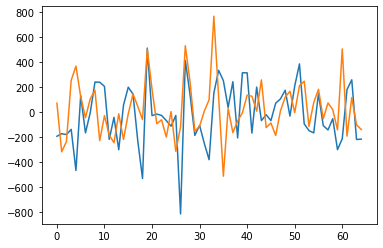

In [63]:
plt.plot(y_test)
plt.plot(model.predict(X_test))

In [64]:
class Model(PyroModule):
    def __init__(self, h1=20, h2=20):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](12, h1)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([h1, 12]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([h1]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))
        self.fc3 = PyroModule[nn.Linear](h2, 1)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([1, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        x = x.reshape(-1, 12)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        mu = self.fc3(x).squeeze()
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        return mu

In [65]:
model = Model()
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 1e-3})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
bar = trange(8000)
x_train = torch.from_numpy(data_feature).float()
y_train = torch.from_numpy(data_target.reshape(-1)).float()
for epoch in bar:
    loss = svi.step(x_train, y_train)
    bar.set_postfix(loss=f'{loss / x_train.shape[0]:.3f}')

  0%|          | 0/8000 [00:00<?, ?it/s]

In [66]:
predictive = Predictive(model, guide=guide, num_samples=500)
preds = predictive(x_train)

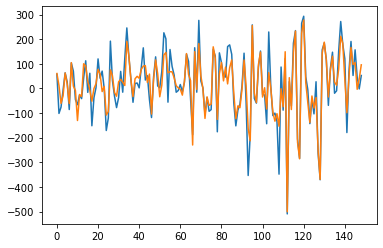

In [67]:
y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
plt.plot(data_target)
plt.plot(y_pred)

In [68]:
preds = predictive(torch.from_numpy(X_test).float())

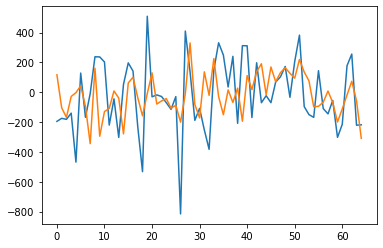

In [69]:
y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
plt.plot(y_test)
plt.plot(y_pred)